In [1]:
import pandas as pd
import numpy as np 
from sklearn.metrics import mean_squared_error
excel_file_path = 'indoor constant illumination OC and MPP BGU.xlsx'

xls = pd.ExcelFile(excel_file_path)

sheet_names_to_extract_input = ['device 1', 'davice 2', 'device 3']
column_arrays_input = np.zeros(( 3, 919))
i=0
for sheet_name_input in sheet_names_to_extract_input:
    df = pd.read_excel(xls, sheet_name_input)
    second_column = df.iloc[:, 1].values
    column_arrays_input[i] = second_column
    i=i+1
indoor_average = np.mean(column_arrays_input, axis=0)
indoor_average.shape

(919,)

In [2]:
import pandas as pd
import numpy as np
excel_file_path = 'Outdoor MPP_Israel_20220822_Triple Cat-BGU fabrication Kenedy for ML.xlsx'
xls = pd.ExcelFile(excel_file_path)
sheet_names = xls.sheet_names
sheet_names_to_extract_output = sheet_names[2:9]
num_sheets = len(sheet_names_to_extract_output)
column_arrays_output = np.zeros((num_sheets, 1782))
for i, sheet_name in enumerate(sheet_names_to_extract_output):
    df = pd.read_excel(xls, sheet_name)
    fourth_column = df.iloc[:, 3].values
    column_arrays_output[i] = fourth_column

outdoor_average = np.mean(column_arrays_output, axis=0)
outdoor_average.shape

(1782,)

In [3]:
import pandas as pd
import numpy as np

excel_file_path = 'Outdoor MPP_Israel_20220822_Triple Cat-BGU fabrication Kenedy for ML.xlsx'

xls = pd.ExcelFile(excel_file_path)

 
sheet_names = xls.sheet_names

 
first_sheet_name = sheet_names[2]
first_sheet_df = pd.read_excel(xls, first_sheet_name)
rh = np.full((1782,), 30)
irradiance= first_sheet_df.iloc[:, 2].values
time = first_sheet_df.iloc[:, 1].values
temperature = first_sheet_df.iloc[:, 6].values
conditions_data = np.column_stack((time,irradiance,rh,temperature))
conditions_data.shape

(1782, 4)

In [4]:
import numpy as np
original_array = np.array(conditions_data)  
pad_length = 4794 - original_array.shape[0]
last_row = original_array[-1]
conditions_data_final = np.vstack([original_array, np.tile(last_row, (pad_length, 1))])
conditions_data_final.shape

(4794, 4)

In [5]:
import numpy as np

indoor_average=indoor_average.reshape(1,919)
outdoor_average=outdoor_average.reshape(1,1782)
indoor_average_final = np.pad(
    indoor_average, ((0, 0), (0, 4794 - indoor_average.shape[1])), mode='edge')
outdoor_average_final = np.pad(
    outdoor_average, ((0, 0), (0, 4794 - outdoor_average.shape[1])), mode='edge')
indoor_average_final=indoor_average_final.reshape(4794,1)
outdoor_average_final= outdoor_average_final.reshape(4794,1)
print(indoor_average_final.shape)
print(outdoor_average_final.shape)

n = 3  
averages = []
for i in range(0, len(outdoor_average_final), n):
    group = outdoor_average_final[i:i + n]
    group_average = np.mean(group)
    averages.append(group_average)

outdoor_average_final = np.array(averages)
outdoor_average_final= outdoor_average_final.reshape(1598,1)

(4794, 1)
(4794, 1)


In [6]:
all_new_features = np.concatenate((indoor_average_final ,conditions_data_final), axis=1)
all_new_features.shape

(4794, 5)

In [9]:
import joblib
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
all_new_features=scaler.fit_transform(all_new_features)
model_filename = 'krr_model.pkl' 
loaded_model = joblib.load(model_filename)
print((all_new_features.reshape(1, -1)) .shape)
predictions = loaded_model.predict((all_new_features.reshape(1,-1)))
mse = mean_squared_error(outdoor_average_final[:,:1598].reshape(1598,-1), predictions[:,:1598].reshape(1598,-1))
mse

(1, 23970)


3.555773236782148

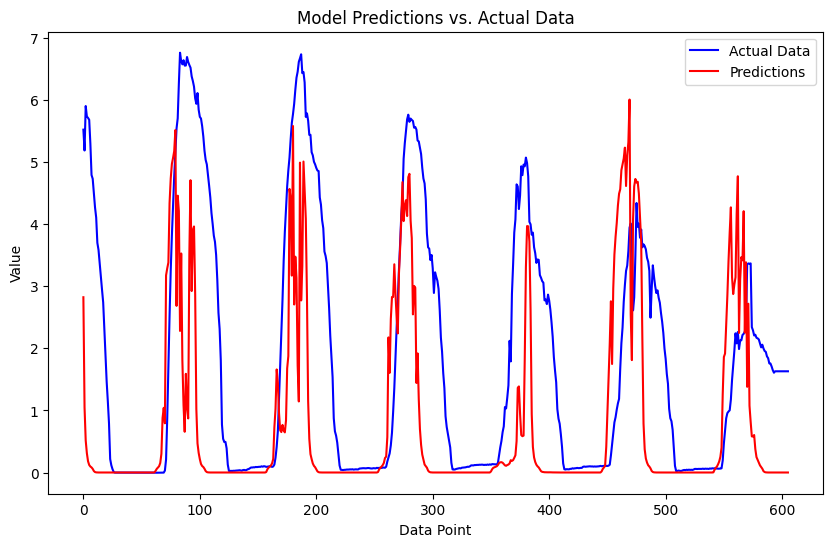

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(outdoor_average_final[:606,:], label='Actual Data', color='blue')
plt.plot(predictions[0,:606], label='Predictions', color='red')
plt.title('Model Predictions vs. Actual Data')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend()
plt.savefig('gpr.png')
plt.show()


